# Important feature Extraction:
### label by cashnote usage

In [85]:
import featuretools as ft
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Load Data

In [3]:
dimension_data_dir = Path('/Users/ed/data/featuretools/biz360_dimension')
df_dimension_raw = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in dimension_data_dir.glob('*.parquet')
)

In [4]:
measure_data_dir = Path('/Users/ed/data/featuretools/biz360_measure')
df_measure_raw = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in measure_data_dir.glob('*.parquet')
)

# df_measure = df_measure_raw[df_measure_raw["time_unit"] == "day"].drop(["visit_count"], axis=1)

In [5]:
uv_data_dir = Path('/Users/ed/data/featuretools/biz360_uv')
df_uv_raw = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in uv_data_dir.glob('*.parquet')
)

In [6]:
df_dimension = df_dimension_raw.drop(["visit_count"], axis=1)

In [ ]:
df_measure = df_measure_raw.copy()
df_measure["business_id"] = df_measure["business_id"].astype("str")
df_measure = df_measure.drop([
 'card_sales__amount_by_age_band__under_20'
,'card_sales__amount_by_age_band__20s'
,'card_sales__amount_by_age_band__30s'
,'card_sales__amount_by_age_band__40s'
,'card_sales__amount_by_age_band__50s'    
,'card_sales__amount_by_age_band__over_60'
,'card_sales__amount_by_gender__male'
,'card_sales__amount_by_gender__female'
,'hometax__sales_invoices_amount'
,'hometax__sales_cash_eceipts_amount'
,'hometax__sales_card_transactions_amount'
,'hometax__purchases_invoices_amount'
,'hometax__purchases_cash_receipts_amount'
,'hometax__hometax_purchases_card_transactions_amount'],axis=1)

# df_measure = df_measure[df_measure["card_sales__amount"].notnull()].drop_duplicates()

df_measure = df_measure[df_measure["time_unit"] == "day"] #.drop(["visit_count"], axis=1)
df_measure["bizid_date_id"] = df_measure.apply(lambda row: f"{row['business_id']}_{row['date_id']}",axis=1)

In [116]:
df_uv = df_uv_raw[(df_uv_raw["business_id"] != 0)]
df_uv["business_id"] = df_uv["business_id"].astype("str")


# df_uv["ts_date"] = pd.to_datetime(df_uv['created_at_date'])
# df_uv["ts_weekofyear"] = pd.to_datetime(df_uv['created_at_date']).dt.weekofyear
# df_uv["ts_year"] = pd.to_datetime(df_uv['created_at_date']).dt.year


# df_uv_agg = df_uv.groupby("business_id").nunique().reset_index()
# df_label_L3 = df_uv[df_uv["visit_count"] >= 3]
# df_label_L3["label"] = True
# # df_label_L2["label"] = False
# df_label = pd.concat([df_label_L3, df_label_L2])
# df_label = df_label.drop("visit_count", axis=1)

## Check: Cashnote Signup Date

In [7]:
df_dimension["created_at_ts"] = pd.to_datetime(df_dimension["businesses__businesses__created_at"])
df_dimension["created_at_month"] = df_dimension.apply(lambda row: str(row["created_at_ts"].month).zfill(2), axis=1)
df_dimension["created_at_year"] = df_dimension.apply(lambda row: str(row["created_at_ts"].year), axis=1)

<AxesSubplot:xlabel='created_at_year,created_at_month'>

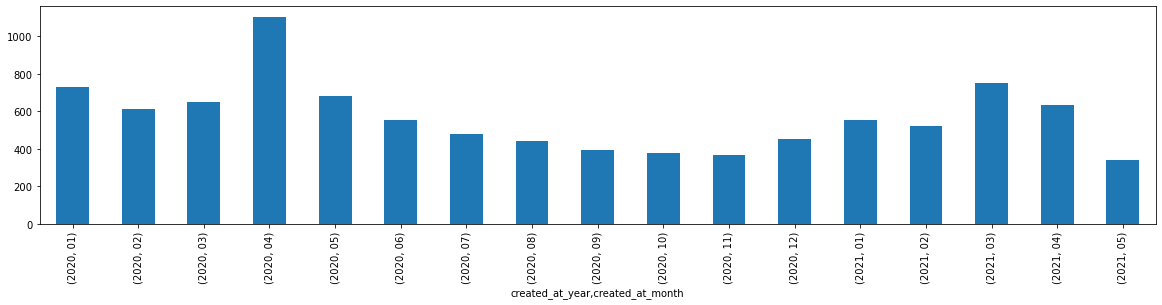

In [8]:
df_dimension[(df_dimension["created_at_year"] >= "2020") & df_dimension["businesses__businesses__created_at"].notnull()].groupby(["created_at_year","created_at_month"]).count()["business_id"].plot.bar(figsize=(20,4))

In [19]:
## Check: User Count

In [15]:
uniq_user_count__dimension = df_dimension_raw.nunique()["business_id"]
uniq_user_count__uv = df_uv_raw.nunique()["business_id"]
uniq_user_count__measure = df_measure_raw.nunique()["business_id"]

print(f"""
- uniq_user_count__dimension: {uniq_user_count__dimension}
- uniq_user_count__measure: {uniq_user_count__measure}
- uniq_user_count__uv: {uniq_user_count__uv}
""")


- uniq_user_count__dimension: 25205
- uniq_user_count__measure: 21730
- uniq_user_count__uv: 25253



In [120]:
df_d = pd.DataFrame(df_dimension_raw["business_id"].unique(),columns=["business_id"])

df_measure["business_id"] = df_measure["business_id"].astype("str")
df_m = pd.DataFrame(df_measure["business_id"].unique(),columns=["business_id"])


df_measure["business_id"] = df_measure["business_id"].astype("str")
user_count_btn_dimension_n_measure = df_d.merge(df_m, on="business_id", how="inner").nunique()["business_id"]
user_count_btn_dimension_n_uv = df_d.merge(df_uv, on="business_id", how="inner").nunique()["business_id"]
user_count_btn_measure_n_uv = df_m.merge(df_uv, on="business_id", how="inner").nunique()["business_id"]


print(f"""
- user_count_btn_dimension_n_measure: {user_count_btn_dimension_n_measure}
- user_count_btn_dimension_n_uv: {user_count_btn_dimension_n_uv}
- user_count_btn_measure_n_uv: {user_count_btn_measure_n_uv}
""")


- user_count_btn_dimension_n_measure: 332
- user_count_btn_dimension_n_uv: 2699
- user_count_btn_measure_n_uv: 357



In [1165]:
df_measure = df_measure_raw.copy()
df_measure["business_id"] = df_measure["business_id"].astype("str")
df_measure = df_measure.drop([
 'card_sales__amount_by_age_band__under_20'
,'card_sales__amount_by_age_band__20s'
,'card_sales__amount_by_age_band__30s'
,'card_sales__amount_by_age_band__40s'
,'card_sales__amount_by_age_band__50s'    
,'card_sales__amount_by_age_band__over_60'
,'card_sales__amount_by_gender__male'
,'card_sales__amount_by_gender__female'
,'hometax__sales_invoices_amount'
,'hometax__sales_cash_eceipts_amount'
,'hometax__sales_card_transactions_amount'
,'hometax__purchases_invoices_amount'
,'hometax__purchases_cash_receipts_amount'
,'hometax__hometax_purchases_card_transactions_amount'],axis=1)

# df_measure = df_measure[df_measure["card_sales__amount"].notnull()].drop_duplicates()

df_measure["bizid_date_id"] = df_measure.apply(lambda row: f"{row['business_id']}_{row['date_id']}",axis=1)



## Label users

In [122]:
df_label = df_uv[["business_id"]]
df_label["label"] = True

In [123]:
df_dimension_label = df_dimension.merge(df_label, on="business_id", how="left")[["business_id","label"]]
df_dimension_label["label"] = df_dimension_label["label"].fillna(False)

In [124]:
df_dimension_label.groupby(["label"]).nunique()

,business_id
label,
False,22506
True,2699


In [983]:
df_dimension_label.head(5)

,business_id,registration_number,cardsales__recent_1_year__amount_sum,cardsales__recent_1_year__amount_avg,cardsales__recent_1_year__tx_count_sum,cardsales__recent_1_year__tx_count_avg,cardsales__recent_1_year__date_cnt,cardsales__recent_1_year__name,cardsales__recent_1_year__recent_1_year_business_id,cardsales__2020_annual__amount_sum,...,businesses__credentials__types__has_CoupangEats,businesses__credentials__types__has_HometaxLogin,businesses__credentials__types__has_Kepco,businesses__credentials__types__has_CardCertificate,businesses__credentials__types__has_CardFranchise,businesses__credentials__types__has_BankAccount,businesses__businesses__crefia_owner_birthday,businesses__businesses__opened_at,hometax__hometax__opened_at,label
0,14473,2300141730,"46,335,900.0000000000","23,167,950.0000000000",848.0000000000,424.0000000000,2.0000000000,recent_1_year,"14,473.0000000000","116,210,100.0000000000",...,False,False,False,False,False,False,1962-09-07,None,None,False
1,53715,8222200682,"23,205,000.0000000000","11,602,500.0000000000",256.0000000000,128.0000000000,2.0000000000,recent_1_year,"53,715.0000000000","234,576,300.0000000000",...,False,False,True,False,False,True,1985-09-03,2017-12-11,2017-12-11,False
2,65290,1700600918,"111,467,500.0000000000","9,288,958.3333333340","4,915.0000000000",409.5833333333,12.0000000000,recent_1_year,"65,290.0000000000","119,821,500.0000000000",...,False,True,True,False,True,False,1965-05-16,2018-02-28,2018-02-28,True
3,80641,2206000118,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,False,False,False,False,False,False,None,None,None,False
4,80854,6759700575,"181,298,000.0000000000","15,108,166.6666666660",687.0000000000,57.2500000000,12.0000000000,recent_1_year,"80,854.0000000000","174,722,000.0000000000",...,False,True,True,False,False,True,1987-09-25,2018-04-02,2018-04-02,False


In [1161]:
df_uv_raw

,business_id,visit_count
0,43527,3
1,597532,5
2,75614,7
3,720158,7
4,91299,6
...,...,...
25248,429112,6
25249,48267,1
25250,352481,2
25251,708429,1


# Feature Creation

Get Categorical Columns

In [125]:
NUMERIC_COLUMNS = []
    
CATEGORICAL_COLUMNS = [] 
for name_type,uniq_cnt in zip(df_dimension_label.dtypes.items() ,df_dimension_label.nunique()):
    name = name_type[0]
    dtype = name_type[1]

    if (uniq_cnt < 50) and (dtype == object) and ("code" not in name):
        CATEGORICAL_COLUMNS.append(name)    
    if (dtype != object):
        NUMERIC_COLUMNS.append(name)

Create the entity of FeatureTools

In [126]:
df_dimension_selected = df_dimension_label[["business_id"] + NUMERIC_COLUMNS + CATEGORICAL_COLUMNS]

# df_dimension_selected = df_dimension_label[["business_id"] + NUMERIC_COLUMNS]
# df_measure_dropna = df_measure.dropna(axis=0)
# df_measure["index"] = df_measure["business_id"].astype(str) + "_" + df_measure["time_date"].astype(str)
# df_dimension_selected = df_dimension_label[["business_id","label" ]]

entities = { \
    "dimension" : (df_dimension_selected.drop_duplicates(),"business_id"), \
    "measure" : (df_measure.drop_duplicates(), "bizid_date_id" )
}

relationships = [("dimension","business_id","measure","business_id")]

es = ft.EntitySet(
    id="cashnote",
    entities=entities,
    relationships = relationships
)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      agg_primitives=["sum","mean","max","min","std"],
                                      target_entity="dimension")
# fm_encoded, f_encoded = ft.encode_features(feature_matrix, features=feature_defs, to_encode=CATEGORICAL_COLUMNS)

fm_encoded, f_encoded = ft.encode_features(feature_matrix, features=feature_defs)

In [127]:
fm_encoded_has_card_sales = fm_encoded[fm_encoded["SUM(measure.card_sales__amount)"] > 0]

X = fm_encoded_has_card_sales.drop("label", axis=1)
y = fm_encoded_has_card_sales["label"]

# X = fm_encoded.dropna(axis=1).drop("label", axis=1)
# y = fm_encoded.dropna(axis=1)["label"]

In [128]:
fm_encoded

,label,MAX(measure.biz_id_hash),MAX(measure.card_sales__amount),MAX(measure.card_sales__count),MAX(measure.card_sales__fee),MAX(measure.card_sales__hourly__0_6),MAX(measure.card_sales__hourly__11_14),MAX(measure.card_sales__hourly__14_17),MAX(measure.card_sales__hourly__17_24),MAX(measure.card_sales__hourly__6_11),...,SUM(measure.delivery__online_amount_sum),SUM(measure.delivery__online_order_count),SUM(measure.delivery__order_count),SUM(measure.delivery__yogiyo_amount_sum),SUM(measure.delivery__yogiyo_offline_amount_sum),SUM(measure.delivery__yogiyo_offline_order_count),SUM(measure.delivery__yogiyo_online_amount_sum),SUM(measure.delivery__yogiyo_online_order_count),SUM(measure.delivery__yogiyo_order_count),SUM(measure.visit_count)
business_id,,,,,,,,,,,,,,,,,,,,,
14473,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
53715,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
65290,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
80641,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
80854,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679938,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
683327,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
693393,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [129]:

X = X.dropna(axis=1)
_X_train, _X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
pd.DataFrame(y_train).reset_index().groupby("label").count()

,business_id
label,
False,197
True,25


In [131]:
pd.DataFrame(y_test).reset_index().groupby("label").count()

,business_id
label,
False,93
True,17


### Feature Selection

In [37]:
# X_new = SelectKBest(chi2, k=10).fit_transform(X,y)
# X_new.shape



### Test Feature Correlation

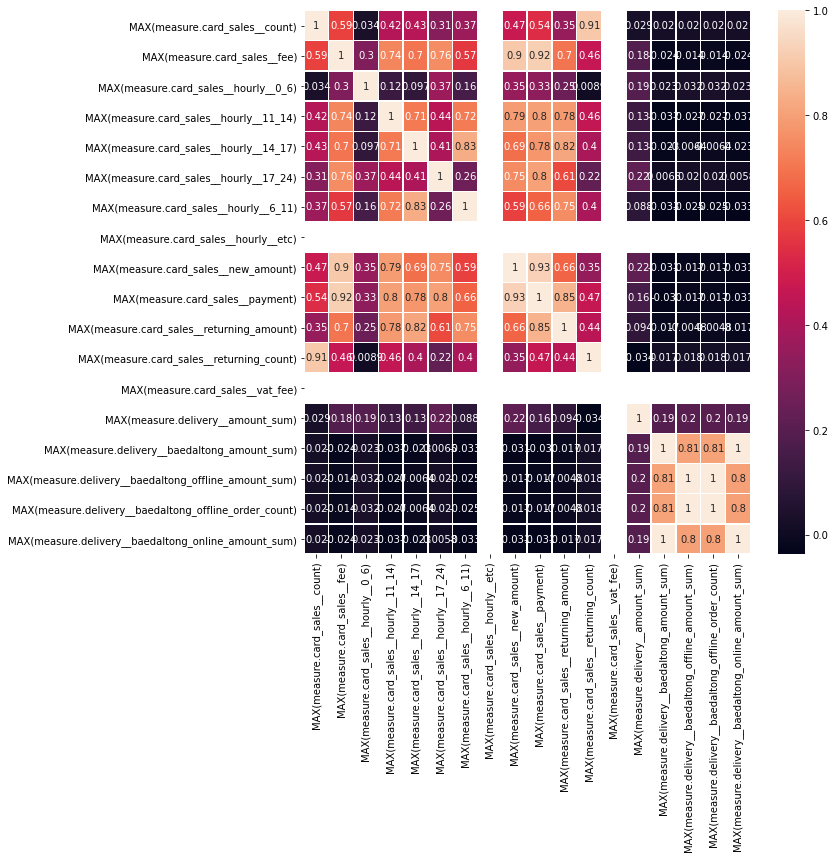

In [132]:
corr = _X_train.corr()
corr = _X_train.iloc[:,2:20].corr()


plt.figure(figsize = (10,10))
ax = sns.heatmap(corr, annot=True, linewidths=.5)

In [133]:
selected_features = set()

for i in range(len(corr .columns)):
    for j in range(i):
        colname1 = corr.columns[i]
        colname2 = corr.columns[j]
        
        if (abs(corr.iloc[i, j]) < 0.1) :
#             print(colname1, colname2, corr.iloc[i, j])
            selected_features.add(colname1)

In [134]:
len(selected_features)

8

In [135]:
list(selected_features)

['MAX(measure.delivery__baedaltong_offline_order_count)',
 'MAX(measure.card_sales__hourly__0_6)',
 'MAX(measure.delivery__amount_sum)',
 'MAX(measure.delivery__baedaltong_offline_amount_sum)',
 'MAX(measure.delivery__baedaltong_online_amount_sum)',
 'MAX(measure.card_sales__returning_count)',
 'MAX(measure.card_sales__hourly__14_17)',
 'MAX(measure.delivery__baedaltong_amount_sum)']

In [136]:
X_train = _X_train[selected_features]
X_test = _X_test[selected_features]

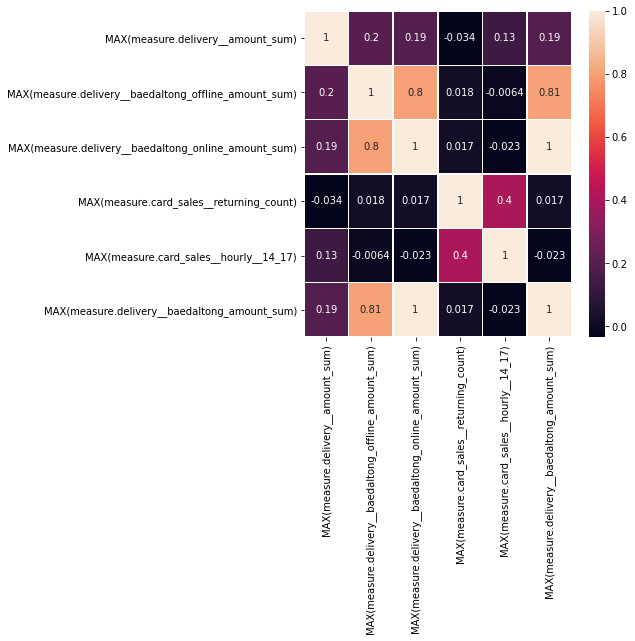

In [137]:
corr = X_train.iloc[:,2:20].corr()


plt.figure(figsize = (6,6))
ax = sns.heatmap(corr, annot=True, linewidths=.5)

## Feature Importance

In [138]:
82198137
import numpy as np

validate_result = f"""
# Train Shape
{X_train.shape}, {y_train.shape}

# Test Shape
{X_test.shape}, {y_test.shape}

# Train Dataset
isnan     : {np.any(np.isnan(X_train))}
isfinite: {np.all(np.isfinite(X_train))}

# Test Dataset
isnan     : {np.any(np.isnan(X_test))}
isfinite: {np.all(np.isfinite(X_test))}"""


print(validate_result)


# Train Shape
(222, 8), (222,)

# Test Shape
(110, 8), (110,)

# Train Dataset
isnan     : False
isfinite: True

# Test Dataset
isnan     : False
isfinite: True


### Logistic Regression

In [140]:
from sklearn.linear_model import LogisticRegression

# Create and fit selector
selector = SelectKBest(chi2, k=20)
selector.fit(X_train, y_train)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_train = X_train.iloc[:,cols]
X_test = X_test.iloc[:,cols]


# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_train_new = X_train.iloc[:,cols]
X_test_new = X_test.iloc[:,cols]

In [141]:
clf_LR = LogisticRegression(random_state=0).fit(X_train, y_train)

# clf.predict(X)
# clf_LR.predict_proba(X_test_new)
clf_LR.score(X_test, y_test)


# 0.7931490384615385
# 0.7939903846153846

/Users/ed/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8272727272727273

In [142]:
from sklearn.metrics import roc_auc_score

y_pred = clf_LR.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.528146742567995

In [102]:
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# print(tn,fp,fn,tp)

In [143]:
features_coef = pd.DataFrame(clf_LR.coef_, columns = X_train.columns)
important_features = features_coef.T.sort_values(by=0, ascending=False).head(100)

In [144]:
important_features_list = list(important_features.index)

In [145]:
pd.options.display.float_format = '{:20,.10f}'.format
important_features.round(10)

,0
SUM(measure.card_sales__amount),0.0000008504
SUM(measure.delivery__yogiyo_amount_sum),0.0000005814
SUM(measure.card_sales__new_amount),0.0000004278
SUM(measure.card_sales__returning_amount),0.0000004226
SUM(measure.delivery__baemin_online_amount_sum),0.0000003298
SUM(measure.delivery__amount_sum),0.0000003184
SUM(measure.card_sales__hourly__0_6),0.0000002608
SUM(measure.card_sales__hourly__11_14),0.0000001884
SUM(measure.card_sales__hourly__6_11),0.0000001481
SUM(measure.card_sales__hourly__17_24),0.0000001477


## RF

In [146]:
from sklearn.ensemble import RandomForestClassifier

X_train = _X_train[[col for col in _X_train.columns if (("id" not in col) and ("DAY" not in col))]]
X_test = _X_test[[col for col in _X_test.columns if (("id" not in col) and ("DAY" not in col))]]




# X_train_new = X_train.drop("DAY(businesses__businesses__created_at)",axis=1) \
#                      .drop("hometax__hometax__bmanclnm = 일반과세자",axis=1) \
#                      .drop("MONTH(businesses__businesses__created_at)",axis=1) \
#                      .drop("classification__ksic__name = ksic",axis=1) \
#                      .drop("businesses__acceptance_templates__complete_polls is unknown",axis=1) \
#                      .drop("location__pnu__name = pnu",axis=1) \
#                      .drop("location__hometax__name = hometax",axis=1) \
#                      .drop("classification__kakao__name = kakao",axis=1)

# X_test_new = X_test.drop("DAY(businesses__businesses__created_at)",axis=1) \
#                      .drop("hometax__hometax__bmanclnm = 일반과세자",axis=1) \
#                      .drop("MONTH(businesses__businesses__created_at)",axis=1) \
#                      .drop("classification__ksic__name = ksic",axis=1) \
#                      .drop("businesses__acceptance_templates__complete_polls is unknown",axis=1) \
#                      .drop("location__pnu__name = pnu",axis=1) \
#                      .drop("location__hometax__name = hometax",axis=1) \
#                      .drop("classification__kakao__name = kakao",axis=1)

In [147]:
print(X_train.shape, X_test.shape)
print(X_train.dropna(axis=1).shape, X_test.dropna(axis=1).shape)



(222, 156) (110, 156)
(222, 156) (110, 156)


In [148]:
clf_RF = RandomForestClassifier(max_depth=8, random_state=3)

clf_RF.fit(X_train.dropna(axis=1), y_train)
clf_RF.score(X_test.dropna(axis=1), y_test)

0.8454545454545455

In [149]:
y_pred = clf_RF.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.44339025932953824

In [150]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, clf_RF.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:50]

# .plot(kind='bar', rot=45)

,Gini-importance
MAX(measure.delivery__offline_amount_sum),0.0199970485
SUM(measure.card_sales__hourly__17_24),0.0181634955
SUM(measure.card_sales__hourly__0_6),0.0180031945
SUM(measure.delivery__baemin_online_order_count),0.0166833781
MAX(measure.card_sales__returning_amount),0.0161885026
MEAN(measure.card_sales__hourly__0_6),0.0159101724
MAX(measure.card_sales__hourly__17_24),0.0158664108
MEAN(measure.delivery__offline_amount_sum),0.0156700447
SUM(measure.delivery__offline_amount_sum),0.0155447586
MEAN(measure.card_sales__fee),0.0153525545


In [151]:
from matplotlib import rc

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False